# Simulador Navier-Stokes

Luis Pablo López Iracheta

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

In [2]:
N_POINTS = 81  # Resolución de la malla  impar para el centro
DOMAIN_SIZE_X = 0.2  # Longitud del tubo [m]
DOMAIN_SIZE_Y = 0.02   # Altura del tubo [m]

# PUNTO 3: Velocidad como entrada (no gradiente de presión)
INLET_VELOCITY = 0.3  # Velocidad máxima deseada [m/s]

# Propiedades del fluido
KINEMATIC_VISCOSITY = 4.0e-6  # Viscosidad cinemática de la sangre [m2/s]
DENSITY = 1050.0  # Densidad [kg/m3]

# Parámetros numéricos
N_ITERATIONS = 3000
TIME_STEP_LENGTH = 0.0003
N_PRESSURE_POISSON_ITERATION = 50

In [3]:
def numero_reynolds_cal(velocity, length_scale, viscosity):
    Re = (velocity * length_scale) / viscosity
    return Re

REYNOLDS_NUMBER = numero_reynolds_cal(
    velocity=INLET_VELOCITY,
    length_scale=DOMAIN_SIZE_Y,
    viscosity=KINEMATIC_VISCOSITY
)


print(f"Velocidad de entrada: {INLET_VELOCITY:.3f} m/s")
print(f"Viscosidad cinemática: {KINEMATIC_VISCOSITY:.6f} m2/s")
print(f"Densidad: {DENSITY:.1f} kg/m3")
print(f"Altura del tubo: {DOMAIN_SIZE_Y:.2f} m")
print(f"\n Número de Reynolds: {REYNOLDS_NUMBER:.2f}")

if REYNOLDS_NUMBER < 2300:
    print("Régimen: LAMINAR ")
elif REYNOLDS_NUMBER < 4000:
    print("Régimen: TRANSICIÓN")
else:
    print("Régimen: TURBULENTO")

Velocidad de entrada: 0.300 m/s
Viscosidad cinemática: 0.000004 m2/s
Densidad: 1050.0 kg/m3
Altura del tubo: 0.02 m

 Número de Reynolds: 1500.00
Régimen: LAMINAR 


In [4]:
def simulate_pipe_flow():
    element_length = DOMAIN_SIZE_Y / (N_POINTS - 1)
    
    # Crear la malla
    x = np.linspace(0.0, DOMAIN_SIZE_X, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE_Y, N_POINTS)
    X, Y = np.meshgrid(x, y)
    
    # Inicializar campos
    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)
    
    # Condición inicial: perfil parabólico
    for j in range(N_POINTS):
        y_pos = y[j]
        u_prev[j, :] = INLET_VELOCITY * 4 * y_pos * (DOMAIN_SIZE_Y - y_pos) / (DOMAIN_SIZE_Y**2)

    # Funciones de diferencias finitas
    def central_difference_x(f):
        diff = np.zeros_like(f)
        dx = DOMAIN_SIZE_X / (N_POINTS - 1)
        diff[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, 0:-2]) / (2 * dx)
        return diff

    def central_difference_y(f):
        diff = np.zeros_like(f)
        dy = DOMAIN_SIZE_Y / (N_POINTS - 1)
        diff[1:-1, 1:-1] = (f[2:, 1:-1] - f[0:-2, 1:-1]) / (2 * dy)
        return diff

    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + 
            f[1:-1, 2:] + f[2:, 1:-1]) / (element_length ** 2)
        return diff

    
    # Loop principal
    for iteration in range(N_ITERATIONS):
        if iteration % 500 == 0:
            print(f"{iteration}", end="...", flush=True)
        
        # Calcular derivadas
        d_u_prev_d_x = central_difference_x(u_prev)
        d_u_prev_d_y = central_difference_y(u_prev)
        d_v_prev_d_x = central_difference_x(v_prev)
        d_v_prev_d_y = central_difference_y(v_prev)
        
        laplace_u_prev = laplace(u_prev)
        laplace_v_prev = laplace(v_prev)

        # Velocidad tentativa
        u_tent = u_prev + TIME_STEP_LENGTH * (
            -(u_prev * d_u_prev_d_x + v_prev * d_u_prev_d_y) 
            + KINEMATIC_VISCOSITY * laplace_u_prev
        )
        
        v_tent = v_prev + TIME_STEP_LENGTH * (
            -(u_prev * d_v_prev_d_x + v_prev * d_v_prev_d_y) 
            + KINEMATIC_VISCOSITY * laplace_v_prev
        )

        # Condiciones de frontera
        u_tent[0, :] = 0.0
        u_tent[-1, :] = 0.0
        v_tent[0, :] = 0.0
        v_tent[-1, :] = 0.0
        
        # PUNTO 3: Entrada con velocidad especificada
        for j in range(N_POINTS):
            y_pos = y[j]
            u_tent[j, 0] = INLET_VELOCITY * 4 * y_pos * (DOMAIN_SIZE_Y - y_pos) / (DOMAIN_SIZE_Y**2)
        v_tent[:, 0] = 0.0
        
        u_tent[:, -1] = u_tent[:, -2]
        v_tent[:, -1] = v_tent[:, -2]

        # Divergencia
        d_u_tent_d_x = central_difference_x(u_tent)
        d_v_tent_d_y = central_difference_y(v_tent)
        rhs = DENSITY / TIME_STEP_LENGTH * (d_u_tent_d_x + d_v_tent_d_y)

        # Poisson para presión
        p_next = p_prev.copy()
        for _ in range(N_PRESSURE_POISSON_ITERATION):
            p_old = p_next.copy()
            p_next[1:-1, 1:-1] = 1/4 * (
                p_old[1:-1, 0:-2] + p_old[0:-2, 1:-1] + 
                p_old[1:-1, 2:] + p_old[2:, 1:-1] - 
                element_length ** 2 * rhs[1:-1, 1:-1]
            )
            
            p_next[:, -1] = 0.0
            p_next[:, 0] = p_next[:, 1]
            p_next[0, :] = p_next[1, :]
            p_next[-1, :] = p_next[-2, :]

        # Corrección de velocidad
        d_p_next_d_x = central_difference_x(p_next)
        d_p_next_d_y = central_difference_y(p_next)
        
        u_next = u_tent - TIME_STEP_LENGTH / DENSITY * d_p_next_d_x
        v_next = v_tent - TIME_STEP_LENGTH / DENSITY * d_p_next_d_y

        # Aplicar BCs finales
        u_next[0, :] = 0.0
        u_next[-1, :] = 0.0
        v_next[0, :] = 0.0
        v_next[-1, :] = 0.0
        
        for j in range(N_POINTS):
            y_pos = y[j]
            u_next[j, 0] = INLET_VELOCITY * 4 * y_pos * (DOMAIN_SIZE_Y - y_pos) / (DOMAIN_SIZE_Y**2)
        v_next[:, 0] = 0.0
        
        u_next[:, -1] = u_next[:, -2]
        v_next[:, -1] = v_next[:, -2]

        u_prev = u_next.copy()
        v_prev = v_next.copy()
        p_prev = p_next.copy()

    
    return u_next, v_next, p_next, X, Y, x, y

# Ejecutar simulación
u, v, p, X, Y, x, y = simulate_pipe_flow()

0...500...1000...1500...2000...2500...

Análisis del Perfil Parabólico

In [5]:
def analyze_velocity_profile(u, v, X, Y, y):
    # Extraer perfil en el centro
    center_x_index = N_POINTS // 2
    u_centerline = u[:, center_x_index]
    
    # Solución analítica de Poiseuille
    y_analytic = np.linspace(0, DOMAIN_SIZE_Y, 200)
    u_analytic = INLET_VELOCITY * 4 * y_analytic * (DOMAIN_SIZE_Y - y_analytic) / (DOMAIN_SIZE_Y**2)
    
    # Calcular errores
    u_numeric_interp = np.interp(y_analytic, y, u_centerline)
    error = np.abs(u_numeric_interp - u_analytic)
    max_error = np.max(error)
    mean_error = np.mean(error)
    relative_error = (max_error / INLET_VELOCITY) * 100
    
    # Verificar parabolicidad
    coeffs = np.polyfit(y, u_centerline, 2)
    u_fitted = np.polyval(coeffs, y)
    r_squared = 1 - (np.sum((u_centerline - u_fitted)**2) / 
                     np.sum((u_centerline - np.mean(u_centerline))**2))
    
    
    print("="*70)
    print(f"Velocidad máxima simulada: {np.max(u_centerline):.6f} m/s")
    print(f"Velocidad máxima esperada: {INLET_VELOCITY:.6f} m/s")
    print(f"\nError máximo: {max_error:.6f} m/s ({relative_error:.2f}%)")
    print(f"Error promedio: {mean_error:.6f} m/s")
    print(f"\nR2 del ajuste parabólico: {r_squared:.6f}")
    
    if r_squared > 0.99:
        print("El perfil es claramente PARABÓLICO")
    elif r_squared > 0.95:
        print("El perfil es aproximadamente parabólico")
    else:
        print("El perfil NO es parabólico")
    print("="*70)
    
    return u_centerline, y_analytic, u_analytic

u_centerline, y_analytic, u_analytic = analyze_velocity_profile(u, v, X, Y, y)

Velocidad máxima simulada: 0.299134 m/s
Velocidad máxima esperada: 0.300000 m/s

Error máximo: 0.001048 m/s (0.35%)
Error promedio: 0.000850 m/s

R2 del ajuste parabólico: 0.999997
El perfil es claramente PARABÓLICO


In [6]:
# Configuración general para todas las figuras
plt.rcParams['axes.titlesize'] = 14 # Tamaño del título
plt.rcParams['axes.labelsize'] = 12 # Tamaño de las etiquetas

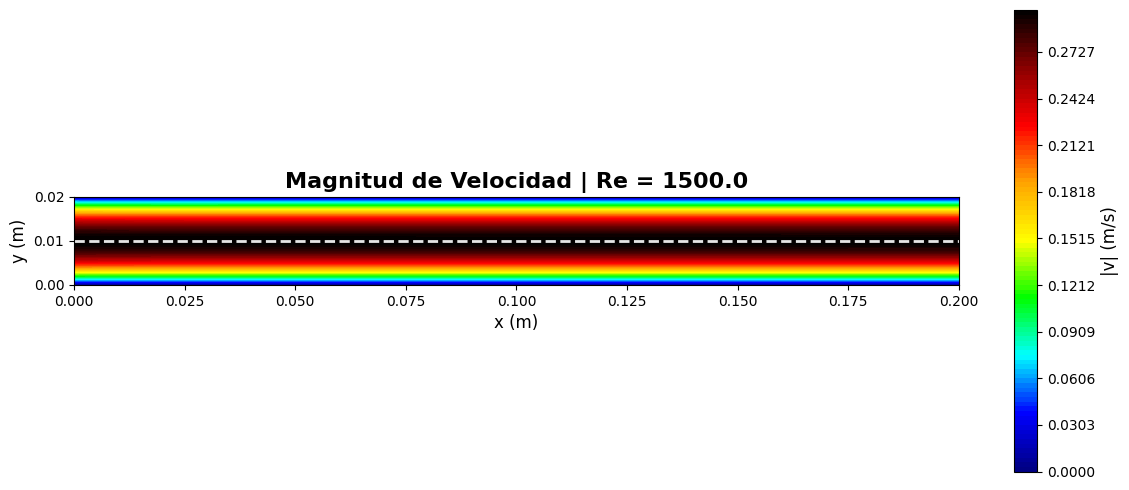

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

# Crear colormap personalizado
colors_list = [
    '#000080',  # Azul oscuro
    '#0000FF',  # Azul
    '#00FFFF',  # Cyan
    '#00FF00',  # Verde
    '#FFFF00',  # Amarillo
    '#FFA500',  # Naranja
    '#FF0000',  # Rojo
    '#8B0000',  # Rojo oscuro
    '#000000'   # Negro
]
multi_color_cmap = LinearSegmentedColormap.from_list("multi_color", colors_list, N=256)

# Calcular magnitud de velocidad
velocity_magnitude = np.sqrt(u**2 + v**2) 

# Contorno de magnitud de velocidad
levels = np.linspace(0, np.max(velocity_magnitude), 100)
contour1 = ax.contourf(X, Y, velocity_magnitude, levels=levels, 
                       cmap=multi_color_cmap)



# Línea central
ax.axhline(y=DOMAIN_SIZE_Y/2, color='white', linestyle='--', linewidth=2, alpha=0.9)

# Configuración de la gráfica
ax.set_title(f'Magnitud de Velocidad | Re = {REYNOLDS_NUMBER:.1f}', 
              fontsize=16, fontweight='bold')
ax.set_xlabel('x (m)', fontsize=12)
ax.set_ylabel('y (m)', fontsize=12)
ax.set_aspect('equal')

# Barra de colores
cbar = plt.colorbar(contour1, ax=ax)
cbar.set_label('|v| (m/s)', fontsize=12)

plt.tight_layout()
plt.show()

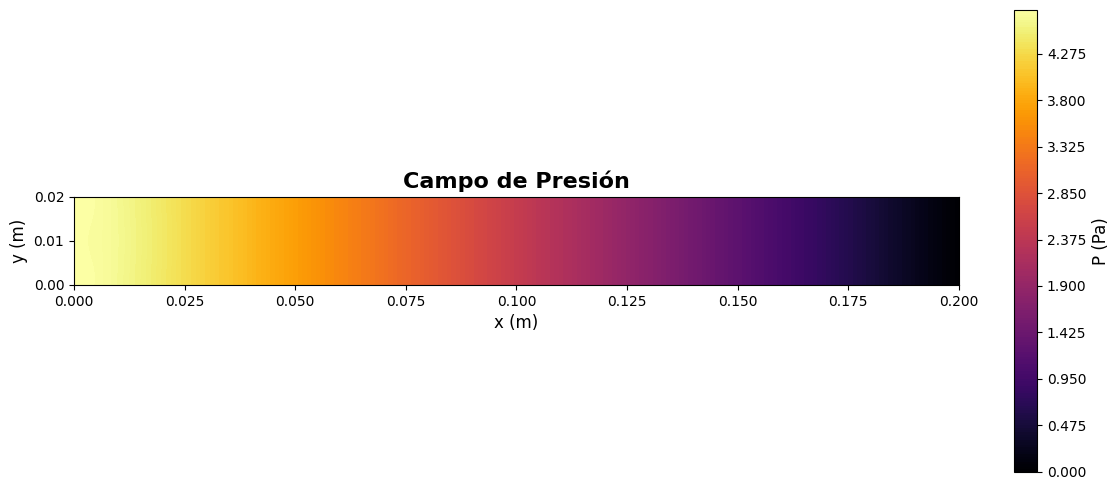

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))

# Contorno de presión
contour = ax.contourf(X, Y, p, levels=200, cmap='inferno')

# Configuración de la gráfica
ax.set_title(f'Campo de Presión', 
              fontsize=16, fontweight='bold')
ax.set_xlabel('x (m)', fontsize=12)
ax.set_ylabel('y (m)', fontsize=12)
ax.set_aspect('equal')

# Barra de colores
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('P (Pa)', fontsize=12)
plt.tight_layout()
plt.show()

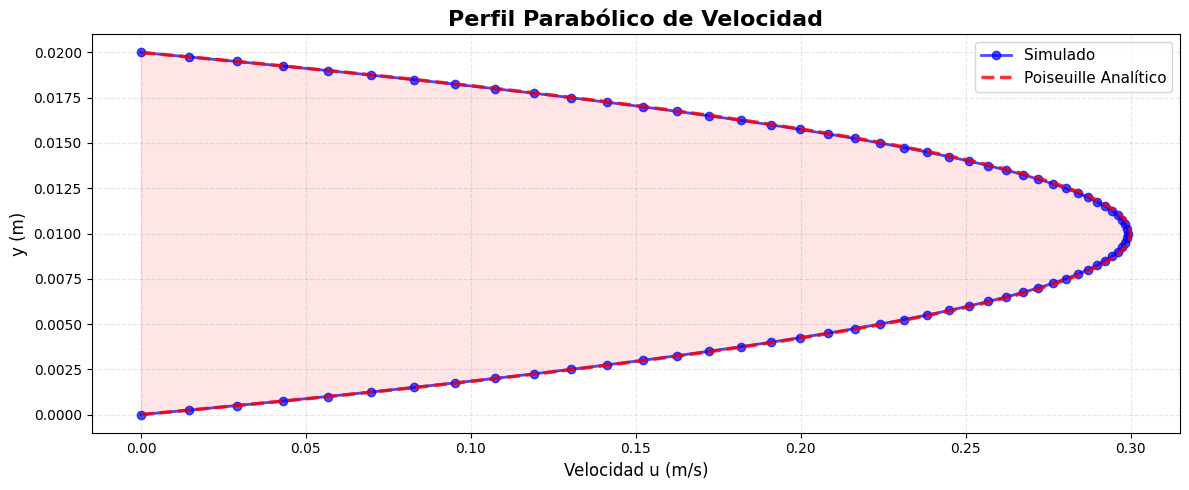

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))

# Perfil simulado
ax.plot(u_centerline, y, 'bo-', linewidth=2, markersize=6, 
         label='Simulado', alpha=0.7, markerfacecolor='blue')

# Perfil analítico (Poiseuille)
ax.plot(u_analytic, y_analytic, 'r--', linewidth=2.5, 
         label='Poiseuille Analítico', alpha=0.8)

# Área sombreada
ax.fill_betweenx(y_analytic, 0, u_analytic, alpha=0.1, color='red')
# Configuración de la gráfica
ax.set_title(f'Perfil Parabólico de Velocidad', 
              fontsize=16, fontweight='bold')
ax.set_xlabel('Velocidad u (m/s)', fontsize=12)
ax.set_ylabel('y (m)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

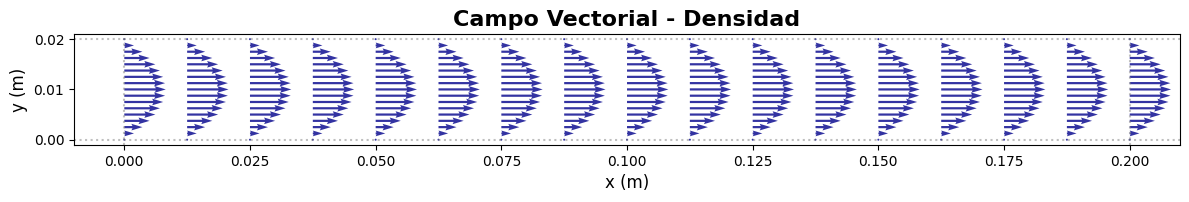

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

density = 5  # Cada 5 puntos
scale_factor = 0.1 * np.max(velocity_magnitude)

# Crear el campo vectorial
quiver = ax.quiver(X[::density, ::density], Y[::density, ::density],
                     u[::density, ::density], v[::density, ::density],
                     color='darkblue',
                     alpha=0.8,
                     width=0.0020,
                     scale=8,  
                     scale_units='width')

# Líneas de referencia
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=DOMAIN_SIZE_Y, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=np.max(X), color='gray', linestyle=':', alpha=0.5)

# Configuración
ax.set_title(f'Campo Vectorial - Densidad', 
               fontsize=16, fontweight='bold')
ax.set_xlabel('x (m)', fontsize=12)
ax.set_ylabel('y (m)', fontsize=12)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()